# Tutorial: Multimodal RNA + ATAC Analysis with SnapATAC2

Audience:
- Computational biologists and bioinformatics users working with single-cell multiome data.

Prerequisites:
- Python environment with `scanpy`, `snapatac2`, `anndata`, and plotting dependencies installed.
- Basic familiarity with AnnData objects and single-cell preprocessing.

Learning goals:
- Load paired RNA and ATAC modalities from a common multiome dataset.
- Build modality-specific embeddings and clusters.
- Build a joint multimodal embedding using `snap.tl.multi_spectral`.


## Outline

1. Setup
2. Discover local samples and checkpoint per-sample files
3. Build combined RNA and ATAC objects from per-sample h5ad
4. RNA preprocessing and embedding
5. ATAC preprocessing and embedding
6. Joint multimodal embedding and clustering
7. Pitfalls, exercises, and extensions


In [14]:
from __future__ import annotations

import importlib
from pathlib import Path

import anndata as ad
import pandas as pd
import scanpy as sc
import snapatac2 as snap
import utils.dbit_rna_reader as dbit_rna_reader

# Force reload so notebook picks up reader edits after restarts.
dbit_rna_reader = importlib.reload(dbit_rna_reader)
discover_rna_tissue_pairs = dbit_rna_reader.discover_rna_tissue_pairs
discover_atac_fragment_tars = dbit_rna_reader.discover_atac_fragment_tars
extract_atac_fragment_archives = dbit_rna_reader.extract_atac_fragment_archives
import_atac_fragments_to_h5ad_per_sample = dbit_rna_reader.import_atac_fragments_to_h5ad_per_sample
read_dbit_rna_directory = dbit_rna_reader.read_dbit_rna_directory
write_rna_h5ad_per_sample = dbit_rna_reader.write_rna_h5ad_per_sample

sc.settings.verbosity = 2
sc.settings.set_figure_params(figsize=(5, 5), frameon=False)

print("scanpy:", sc.__version__)
print("snapatac2:", snap.__version__)


scanpy: 1.11.5
snapatac2: 2.8.0


/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_86456/3232054202.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print("scanpy:", sc.__version__)


## Step 1 - Discover local DBiT RNA + ATAC samples

Discover all RNA/tissue pairs and matching ATAC tar files under `data-RNA` recursively (`atac/` and `cut_and_tag/`).


In [2]:
data_root = Path("data-RNA/atac")
pairs = discover_rna_tissue_pairs(data_root, recursive=True)
required = {"RNA_matrix", "tissue_positions_list"}
sample_ids = sorted([s for s, files in pairs.items() if required.issubset(files)])

if not sample_ids:
    raise RuntimeError(f"No complete RNA+tissue sample pairs found under {data_root}")

atac_tar_manifest = discover_atac_fragment_tars(
    data_dir=data_root,
    sample_ids=sample_ids,
    recursive=True,
)

sample_manifest = pd.DataFrame({"sample_id": sample_ids})
sample_manifest["has_atac_tar"] = sample_manifest["sample_id"].isin(set(atac_tar_manifest["sample_id"]))
print(f"Discovered RNA samples: {len(sample_ids)}")
print(f"Samples with ATAC tar: {sample_manifest['has_atac_tar'].sum()}")
sample_manifest


Discovered RNA samples: 7
Samples with ATAC tar: 7


,sample_id,has_atac_tar
0,06_LPC5S1,True
1,06_LPC5S2,True
2,07_LPC10S1,True
3,07_LPC10S2,True
4,08_LPC21S1,True
5,08_LPC21S2,True
6,LPC5_Saggital,True


### Step 1b - Checkpoint per-sample RNA h5ad and extracted ATAC fragments

Write one RNA h5ad per sample and extract fragment files from ATAC tar archives. These steps are resumable with `overwrite=False`.


In [ ]:
checkpoint_dir = Path("data/checkpoints")
rna_h5ad_dir = checkpoint_dir / "rna_h5ad_by_sample"
atac_frag_dir = checkpoint_dir / "atac_fragments_local"
atac_h5ad_dir = checkpoint_dir / "atac_h5ad_by_sample"

rna_h5ad_manifest = write_rna_h5ad_per_sample(
    data_dir=data_root,
    out_dir=rna_h5ad_dir,
    sample_ids=sample_ids,
    overwrite=False,
    recursive=True,
)

dbit_atac_manifest = extract_atac_fragment_archives(
    out_dir=atac_frag_dir,
    atac_manifest=atac_tar_manifest,
    overwrite=False,
)

print(f"RNA h5ad files: {(rna_h5ad_manifest['status'] != 'error').sum()}")
print(f"Extracted ATAC fragment sets: {len(dbit_atac_manifest)}")
rna_h5ad_manifest.head()


RNA h5ad files: 7
Extracted ATAC fragment sets: 7


,sample_id,status,rna_h5ad,rna_tar,tissue_positions_tar,n_obs,n_vars
0,06_LPC5S1,skipped_existing,data/checkpoints/rna_h5ad_by_sample/06_LPC5S1....,data-RNA/atac/06_LPC5S1_RNA_matrix.csv.tar,data-RNA/atac/06_LPC5S1_tissue_positions_list....,-1,-1
1,06_LPC5S2,written,data/checkpoints/rna_h5ad_by_sample/06_LPC5S2....,data-RNA/atac/06_LPC5S2_RNA_matrix.csv.tar,data-RNA/atac/06_LPC5S2_tissue_positions_list....,8169,32285
2,07_LPC10S1,written,data/checkpoints/rna_h5ad_by_sample/07_LPC10S1...,data-RNA/atac/07_LPC10S1_RNA_matrix.csv.tar,data-RNA/atac/07_LPC10S1_tissue_positions_list...,8180,32285
3,07_LPC10S2,written,data/checkpoints/rna_h5ad_by_sample/07_LPC10S2...,data-RNA/atac/07_LPC10S2_RNA_matrix.csv.tar,data-RNA/atac/07_LPC10S2_tissue_positions_list...,8928,32285
4,08_LPC21S1,written,data/checkpoints/rna_h5ad_by_sample/08_LPC21S1...,data-RNA/atac/08_LPC21S1_RNA_matrix.csv.tar,data-RNA/atac/08_LPC21S1_tissue_positions_list...,8485,32285


In [ ]:
RUN_LOCAL_ATAC_IMPORT = True
USE_RNA_BARCODE_WHITELIST = True
CONTINUE_ON_ERROR = True

if RUN_LOCAL_ATAC_IMPORT:
    # Choose the correct genome for your experiment, e.g., snap.genome.mm10 or snap.genome.hg38.
    genome = snap.genome.mm10

    whitelist_by_sample = None
    if USE_RNA_BARCODE_WHITELIST:
        whitelist_by_sample = {}
        for row in rna_h5ad_manifest.itertuples(index=False):
            sample_id = str(row.sample_id)
            a = sc.read_h5ad(str(row.rna_h5ad))
            if "barcode" in a.obs.columns:
                barcodes = a.obs["barcode"].astype(str).tolist()
            else:
                barcodes = a.obs_names.astype(str).tolist()
            whitelist_by_sample[sample_id] = barcodes
            del a

    atac_h5ad_manifest = import_atac_fragments_to_h5ad_per_sample(
        out_dir=atac_h5ad_dir,
        genome=genome,
        atac_manifest=dbit_atac_manifest,
        whitelist_by_sample=whitelist_by_sample,
        sorted_by_barcode=False,
        overwrite=True,
        continue_on_error=CONTINUE_ON_ERROR,
    )
    atac_h5ad_manifest
else:
    print("Set RUN_LOCAL_ATAC_IMPORT=True to import ATAC and write per-sample h5ad files.")


## Step 2 - Build paired local RNA and ATAC objects from per-sample h5ad

Load a subset of sample-level checkpoints first (recommended), then scale up to all samples after confirming memory usage.


In [5]:
# Recover manifests after kernel restart if needed.
if "rna_h5ad_manifest" not in globals():
    rna_h5ad_manifest = pd.DataFrame(
        {
            "sample_id": p.name.replace(".rna.h5ad", ""),
            "rna_h5ad": str(p),
            "status": "existing",
        }
        for p in sorted((Path("data/checkpoints") / "rna_h5ad_by_sample").glob("*.rna.h5ad"))
    )

if "atac_h5ad_manifest" not in globals():
    atac_h5ad_manifest = pd.DataFrame(
        {
            "sample_id": p.name.replace(".atac.h5ad", ""),
            "atac_h5ad": str(p),
            "status": "existing",
        }
        for p in sorted((Path("data/checkpoints") / "atac_h5ad_by_sample").glob("*.atac.h5ad"))
    )

rna_ok = set(rna_h5ad_manifest["sample_id"].astype(str))
atac_ok = set(atac_h5ad_manifest.loc[atac_h5ad_manifest["status"] != "error", "sample_id"].astype(str))
shared_samples = sorted(rna_ok.intersection(atac_ok))
if not shared_samples:
    raise RuntimeError("No shared RNA/ATAC sample-level h5ad files found.")

# Start small to avoid OOM; set to `shared_samples` for all samples.
samples_to_build = shared_samples[:2]
print("Shared samples:", shared_samples)
print("Building combined objects from samples:", samples_to_build)

rna_parts = []
for sample_id in samples_to_build:
    row = rna_h5ad_manifest.loc[rna_h5ad_manifest["sample_id"].astype(str) == sample_id].iloc[0]
    a = sc.read_h5ad(str(row.rna_h5ad))
    a.obs["sample_id"] = str(sample_id)
    if "barcode" not in a.obs.columns:
        a.obs["barcode"] = a.obs_names.astype(str)
    a.obs["barcode"] = a.obs["barcode"].astype(str)
    a.obs_names = (a.obs["sample_id"] + ":" + a.obs["barcode"]).to_numpy()
    a.obs_names_make_unique()
    rna_parts.append(a)

atac_parts = []
for sample_id in samples_to_build:
    row = atac_h5ad_manifest.loc[atac_h5ad_manifest["sample_id"].astype(str) == sample_id].iloc[0]
    try:
        a = snap.read(str(row.atac_h5ad), backed=None)
    except Exception:
        a = sc.read_h5ad(str(row.atac_h5ad))
    a.obs["sample_id"] = str(sample_id)
    a.obs["barcode"] = a.obs_names.astype(str).str.replace(r"-[0-9]+$", "", regex=True)
    a.obs_names = (a.obs["sample_id"] + ":" + a.obs["barcode"]).to_numpy()
    a.obs_names_make_unique()
    atac_parts.append(a)

rna = ad.concat(rna_parts, join="outer", merge="first")
atac = ad.concat(atac_parts, join="outer", merge="first")

print(rna)
print(atac)
print("Shared barcodes:", len(rna.obs_names.intersection(atac.obs_names)))


Shared samples: ['06_LPC5S1', '06_LPC5S2', '07_LPC10S1', '07_LPC10S2', '08_LPC21S1', '08_LPC21S2', 'LPC5_Saggital']
Building combined objects from samples: ['06_LPC5S1', '06_LPC5S2']


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 16905 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'barcode', 'sample_id'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 16905 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'sample_id', 'barcode'
    obsm: 'fragment_paired'
Shared barcodes: 16905


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Step 3 - RNA preprocessing and embedding

Use a standard Scanpy workflow to build an RNA latent space and clusters.


In [6]:
# Checkpoint workflow: keep this placeholder cell to separate data loading from preprocessing.


In [7]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna)

rna.raw = rna
rna = rna[:, rna.var["highly_variable"]].copy()

sc.pp.scale(rna)
sc.pp.pca(rna, n_comps=50)
sc.pp.neighbors(rna)
sc.tl.umap(rna)
sc.tl.leiden(rna)


normalizing counts per cell


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
computing PCA
    with n_comps=50


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished (0:00:12)
computing UMAP
    finished (0:00:05)
running Leiden clustering


/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_86456/144694855.py:12: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna)


    finished (0:00:05)


... storing 'barcode' as categorical
... storing 'sample_id' as categorical


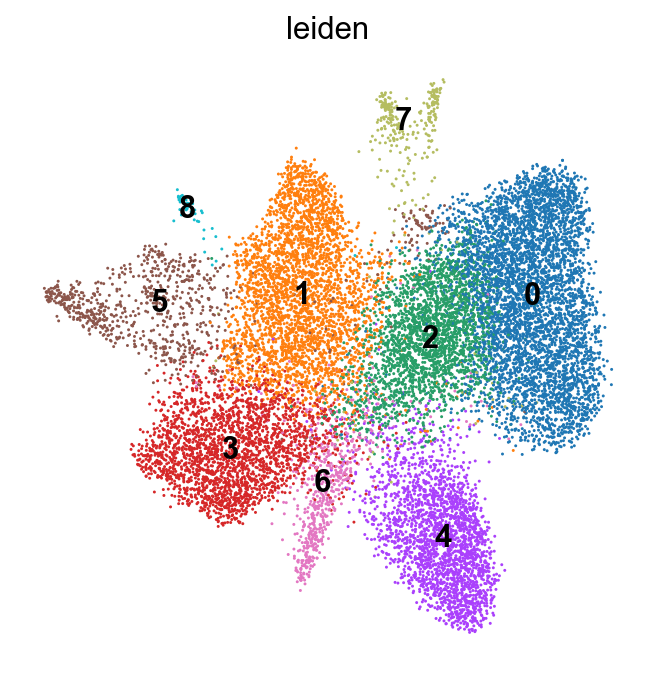

In [8]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")


## Step 4 - ATAC preprocessing and embedding

Run SnapATAC2 feature selection, spectral embedding, neighborhood graph, and clustering.


In [12]:
atac.obs

,n_fragment,frac_dup,frac_mito,sample_id,barcode
06_LPC5S1:AAACATCGAAACATCG,7833,0.389240,0.0,06_LPC5S1,AAACATCGAAACATCG
06_LPC5S1:AAACATCGAACAACCA,15408,0.426786,0.0,06_LPC5S1,AAACATCGAACAACCA
06_LPC5S1:AAACATCGAACCGAGA,17108,0.431382,0.0,06_LPC5S1,AAACATCGAACCGAGA
06_LPC5S1:AAACATCGAACGCTTA,16503,0.439779,0.0,06_LPC5S1,AAACATCGAACGCTTA
06_LPC5S1:AAACATCGAACGTGAT,9451,0.431485,0.0,06_LPC5S1,AAACATCGAACGTGAT
...,...,...,...,...,...
06_LPC5S2:TTCACGCATGAAGAGA,13839,0.408666,0.0,06_LPC5S2,TTCACGCATGAAGAGA
06_LPC5S2:TTCACGCATGGAACAA,24722,0.426523,0.0,06_LPC5S2,TTCACGCATGGAACAA
06_LPC5S2:TTCACGCATGGCTTCA,29515,0.429871,0.0,06_LPC5S2,TTCACGCATGGCTTCA
06_LPC5S2:TTCACGCATGGTGGTA,17029,0.417812,0.0,06_LPC5S2,TTCACGCATGGTGGTA


In [ ]:
snap.pp.select_features(atac)
snap.tl.spectral(atac)
snap.pp.knn(atac)
snap.tl.umap(atac)
snap.tl.leiden(atac)


TypeError: 'NoneType' object is not subscriptable

In [ ]:
snap.pl.umap(atac, color="leiden", show=True)


## Step 5 - Joint multimodal embedding

Align cells between modalities, build a multimodal container, and compute a joint representation.


In [ ]:
shared_cells = rna.obs_names.intersection(atac.obs_names)
rna_shared = rna[shared_cells].copy()
atac_shared = atac[shared_cells].copy()

out_path = Path("data/dbit_local_multimodal.h5ads")
out_path.parent.mkdir(parents=True, exist_ok=True)

mdata = snap.AnnDataSet(
    adatas=[rna_shared, atac_shared],
    filename=str(out_path),
)
mdata


In [ ]:
snap.tl.multi_spectral(mdata)
snap.pp.knn(mdata)
snap.tl.umap(mdata)
snap.tl.leiden(mdata)


In [ ]:
snap.pl.umap(mdata, color="leiden", show=True)


## Pitfalls and Extensions

Common pitfalls:
- The RNA and ATAC objects must share cell barcodes. If they do not, integration is not meaningful.
- Keep ATAC in memory (`backed=None`) for this workflow because graph construction needs writable arrays.
- If memory is limited, reduce feature counts before `snap.tl.spectral`.

Extension ideas:
- Compare modality-specific and multimodal clusters with contingency tables.
- Add marker-gene and marker-peak annotation for biological interpretation.
- Re-run integration after changing ATAC feature selection parameters.


## Exercises

1. Compare multimodal Leiden clusters against RNA-only Leiden clusters with a contingency table.
2. Recompute ATAC embeddings with a different feature-selection threshold and compare cluster stability.


In [ ]:
# Exercise answer scaffold
import pandas as pd

comparison = pd.concat(
    [
        rna_shared.obs["leiden"].rename("rna_leiden"),
        atac_shared.obs["leiden"].rename("atac_leiden"),
        mdata.obs["leiden"].rename("multi_leiden"),
    ],
    axis=1,
).dropna()

comparison.head()


In [ ]:
pd.crosstab(comparison["multi_leiden"], comparison["rna_leiden"])
